# Fine‑tuning CLIP on Leaf‑Disease Images

This notebook fine‑tunes the **CLIP ViT‑B/32** model on ~500 images of diseased leaves.
Dataset layout:
```
Dataset/
├── burn/
├── rot/
├── spot/
├── powder mildew/
└── chlorosis/
```
Each sub‑folder contains class‑specific images.

We follow the workflow used in the template notebook:
1. Load the dataset with `datasets.load_dataset('imagefolder')`.
2. Build `InputExample` objects for **image‑text contrastive learning**.
3. Freeze most layers, training only lightweight projection layers.
4. Optimise with **MultipleNegativesRankingLoss**.
5. Evaluate with a simple **image‑to‑text retrieval accuracy**.


In [ ]:
# 1️⃣  Making sure 7‑Zip CLI is present (one‑time per session, <10 s)
!apt-get -qq update
!apt-get -qq install -y p7zip-full

# 2️⃣  Set paths ── adjust filenames / folders as needed
ARCHIVE="/content/dataset.7z"      # ← exact path to the .7z
TARGET="/content/dataset"

# 3️⃣  Extract
!mkdir -p "$TARGET"
!7z x "$ARCHIVE" -o"$TARGET"            # -o specifies the output dir

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 42268186 bytes (41 MiB)

Extracting archive: /content/dataset.7z
--
Path = /content/dataset.7z
Type = 7z
Physical Size = 42268186
Headers Size = 11170
Method = LZMA2:25
Solid = +
Blocks = 1

  0%    
Would you like to replace the existing file:
  Path:     /content/dataset/dataset/burn/-_100_jpeg.rf.2f3091f5b4dfeaca9c096eb98d450482.jpg
  Size:     92925 bytes (91 KiB)
  Modified: 2025-05-14 12:37:53
with the file from archive:
  Path:     dataset/burn/-_100_jpeg.rf.2f3091f5b4dfeaca9c

In [ ]:
!pip install -U "datasets>=2.19.1" "huggingface_hub>=0.21.2" "fsspec>=2023.12"  \
  --quiet

In [ ]:
from pathlib import Path
import random, torch, numpy as np, matplotlib.pyplot as plt
from datasets import load_dataset, DatasetDict
from PIL import Image
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    InputExample,
)
from sentence_transformers.losses import MultipleNegativesRankingLoss

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running on', device)

Running on cuda


In [ ]:
# ─── Config ──────────────────────────────────────────────
DATA_DIR    = Path('dataset/dataset')          # root folder
BATCH_SIZE  = 16
NUM_EPOCHS  = 10
LR          = 1e-4
MODEL_NAME  = 'sentence-transformers/clip-ViT-B-32'


In [ ]:
# ─── Load & split dataset ───────────────────────────────
dataset = load_dataset("imagefolder", data_dir=str(DATA_DIR))

# stratified split 70 / 15 / 15
train_valid = dataset["train"].train_test_split(test_size=0.30, seed=42)
valid_test  = train_valid["test"].train_test_split(test_size=0.50, seed=42)
dataset = DatasetDict({
    "train": train_valid["train"],
    "valid": valid_test["train"],
    "test":  valid_test["test"],
})
print(dataset)

Resolving data files:   0%|          | 0/466 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 326
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 70
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 70
    })
})


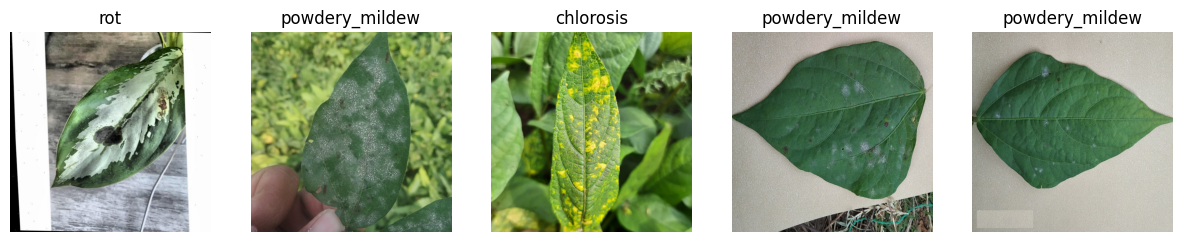

In [ ]:
# ─── Visual inspection ──────────────────────────────────
labels = dataset['train'].features['label'].names
def show_examples(ds, n=5):
    rows = min(n, len(ds))
    fig, axs = plt.subplots(1, rows, figsize=(3*rows, 3))
    for i, idx in enumerate(random.sample(range(len(ds)), rows)):
        img = ds[idx]['image']
        label = labels[ds[idx]['label']]
        axs[i].imshow(img)
        axs[i].set_title(label)
        axs[i].axis('off')
    plt.show()

show_examples(dataset['train'])

In [ ]:
# ─── Model ───────────────────────────────────────────────
model = SentenceTransformer(MODEL_NAME, device=device)

# Freeze all layers except projection & LayerNorm
trainable_layers = ['projection', 'LayerNorm']
for name, param in model.named_parameters():
    param.requires_grad = any(t in name for t in trainable_layers)
print('Trainable parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

Trainable parameters: 655360


In [ ]:
# ─── Build InputExample list ─────────────────────────────
from sentence_transformers import InputExample

def example_from_row(row):
    # PIL.Image object goes *first*, class-name text goes second
    return InputExample(
        texts=[row["image"], labels[row["label"]]]
    )

train_samples = [example_from_row(r) for r in dataset["train"]]
valid_samples = [example_from_row(r) for r in dataset["valid"]]
test_samples  = [example_from_row(r) for r in dataset["test"]]

print('Samples:', len(train_samples), len(valid_samples), len(test_samples))

Samples: 326 70 70


In [ ]:
# ─── Training setup ─────────────────────────────────────
training_args = SentenceTransformerTrainingArguments(
    output_dir        = './clip‑leaf‑disease',
    num_train_epochs  = NUM_EPOCHS,
    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size  = BATCH_SIZE,
    learning_rate     = LR,
    eval_strategy = 'epoch',
    fp16              = torch.cuda.is_available(),
    save_total_limit  = 2,
)

loss = MultipleNegativesRankingLoss(model)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# ─── Train ───────────────────────────────────────────────
from sentence_transformers import SentenceTransformer, losses, InputExample
from torch.utils.data import DataLoader
from sentence_transformers import losses

# Disable W&B logging
import os
os.environ["WANDB_DISABLED"] = "true"



# Define DataLoaders for training and validation
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=16)

# Define the loss function
train_loss = losses.MultipleNegativesRankingLoss(model)

# Train using SentenceTransformer's built-in trainer
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=10,
    warmup_steps=100,
    output_path="output/clip-leaf-finetuned",
    show_progress_bar=True
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


In [ ]:
import torch.nn.functional as F

def retrieval_accuracy(model, samples):
    # Encode class labels
    class_names = [labels[i] for i in range(len(labels))]
    text_emb = model.encode(
        class_names, convert_to_tensor=True, batch_size=len(class_names),
        device=device, show_progress_bar=False
    )

    correct = 0
    for ex in samples:
        image = ex.texts[0]     # this is the PIL image
        true_class = ex.texts[1]  # this is the correct label as string

        img_emb = model.encode(
            image, convert_to_tensor=True, device=device,
            show_progress_bar=False
        )

        sims = F.cosine_similarity(img_emb, text_emb)
        pred_idx = torch.argmax(sims).item()

        if class_names[pred_idx] == true_class:
            correct += 1

    return correct / len(samples)


In [ ]:
print('Train  acc:', retrieval_accuracy(model, train_samples))
print('Valid  acc:', retrieval_accuracy(model, valid_samples))
print('Test   acc:', retrieval_accuracy(model, test_samples))

Train  acc: 0.9570552147239264
Valid  acc: 0.9428571428571428
Test   acc: 0.9285714285714286


In [ ]:
# ─── Save model ─────────────────────────────────────────
model.save('./clip‑leaf‑disease‑finetuned')
print('Model saved ✅')

Model saved ✅


In [ ]:
# ─── Inference example ─────────────────────────────────
def predict(image_path):
    img   = Image.open(image_path).convert('RGB')
    texts = [f'{cls} disease' for cls in labels]

    img_emb   = model.encode(img, convert_to_tensor=True)
    text_embs = model.encode(texts, convert_to_tensor=True)

    sims  = torch.nn.functional.cosine_similarity(img_emb, text_embs)
    order = torch.argsort(sims, descending=True).cpu().numpy()

    for idx in order:
        print(f'{labels[idx]:<15}: {sims[idx]:.3f}')
    print("\nPrediction:", labels[order[0]])

# predict('Aziz.jpg')
# predict("c5.jpeg")
# predict("burn8.jpg")
# predict("c1.jpeg")
predict("home_leaf_burn.jpg")


NameError: name 'Image' is not defined

In [ ]:
pom google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!zip -r clip_finetuned2.zip clip‑leaf‑disease‑finetuned/


  adding: clip‑leaf‑disease‑finetuned/ (stored 0%)
  adding: clip‑leaf‑disease‑finetuned/README.md (deflated 63%)
  adding: clip‑leaf‑disease‑finetuned/vocab.json (deflated 62%)
  adding: clip‑leaf‑disease‑finetuned/config_sentence_transformers.json (deflated 34%)
  adding: clip‑leaf‑disease‑finetuned/modules.json (deflated 23%)
  adding: clip‑leaf‑disease‑finetuned/model.safetensors (deflated 35%)
  adding: clip‑leaf‑disease‑finetuned/preprocessor_config.json (deflated 50%)
  adding: clip‑leaf‑disease‑finetuned/tokenizer.json (deflated 83%)
  adding: clip‑leaf‑disease‑finetuned/tokenizer_config.json (deflated 64%)
  adding: clip‑leaf‑disease‑finetuned/merges.txt (deflated 60%)
  adding: clip‑leaf‑disease‑finetuned/config.json (deflated 66%)
  adding: clip‑leaf‑disease‑finetuned/special_tokens_map.json (deflated 73%)


In [ ]:
from google.colab import files
files.download('clip_finetuned2.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>